# ITER TBR Calculation
Goal : Build a working ITER TBR Simulation

Name : Husni Naufal Zuhdi (413821)

In [1]:
# Import all packages needed
# Basic numerical packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Jupyter Cadquery to see geometry in 3d
from jupyter_cadquery.cadquery import (PartGroup, Part, Edges, Faces, Vertices, show)
from jupyter_cadquery import set_sidecar, set_defaults, reset_defaults

# Monte Carlo related packages
import openmc
import paramak
import paramak_neutronics as nparamak
import neutronics_material_maker as nmm

Overwriting auto display for cadquery Workplane and Shape


## Step 1 : Define Materials

The materials use in this study are listed below
1. Plasma = Low Density U235
2. Blanket Fluid = LiF
3. Neutron Multiplier = Natural Pb
4. Reflector = Graphite
5. First Wall= SS 316 LN
6. Divertor= SS 316 LN
7. Vaccum Vessel= SS 316 LN

In [2]:
# Plasma Material
plasma_mat = nmm.Material(
    name='U235',
    isotopes={'U235':1},
    density=1e-6,
    percent_type='ao',
    density_unit='g/cm3'
)
plasma_mat.openmc_material

Material
	ID             =	2
	Name           =	U235
	Temperature    =	None
	Density        =	1e-06 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	U235           =	1            [ao]

In [3]:
# Blanket Fluid Material
enrichment_Li = 10
blanket_fluid_mat = nmm.Material.from_library(name='Lithium Fluoride',
                                        enrichment=enrichment_Li,
                                        enrichment_target='Li6',
                                        enrichment_type='ao'
                                       )
blanket_fluid_mat.openmc_material

Material
	ID             =	4
	Name           =	Lithium Fluoride
	Temperature    =	None
	Density        =	2.635 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Li6            =	0.05         [ao]
	Li7            =	0.45         [ao]
	F19            =	0.5          [ao]

In [4]:
# Neutron Multiplier and Moderator Material
neutron_multi = 0
neutron_multi_mat = nmm.Material.from_library(name='Lead')
neutron_multi_mat.name = 'neutron_multi_mat'

mod_mat = nmm.Material(
    name='Graphite',
    elements={'C':1},
    density=2.23,
    percent_type='ao',
    density_unit='g/cm3'
)
mod_mat.name = 'mod_mat'

blanket_mod_mat = nmm.Material.from_mixture(materials=[neutron_multi_mat, mod_mat],
                        fracs=[neutron_multi, (1-neutron_multi)],
                        percent_type='vo')
blanket_mod_mat.name = 'blanket_mod_mat'
blanket_mod_mat.openmc_material

Material
	ID             =	11
	Name           =	blanket_mod_mat
	Temperature    =	None
	Density        =	2.229999999999999 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	C12            =	0.9889220000000001 [ao]
	C13            =	0.011078     [ao]
	Pb204          =	0.0          [ao]
	Pb206          =	0.0          [ao]
	Pb207          =	0.0          [ao]
	Pb208          =	0.0          [ao]

In [5]:
# Reflector Materials
blanket_ref_mat = nmm.Material(
    name='Graphite',
    elements={'C':1},
    density=2.23,
    percent_type='ao',
    density_unit='g/cm3'
)
blanket_ref_mat.openmc_material

Material
	ID             =	13
	Name           =	Graphite
	Temperature    =	None
	Density        =	2.23 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	C12            =	0.988922     [ao]
	C13            =	0.011078     [ao]

In [6]:
# First Wall Material
blanket_first_wall_mat = nmm.Material.from_library('Steel, Stainless 316')
blanket_first_wall_mat.openmc_material

Material
	ID             =	15
	Name           =	Steel, Stainless 316
	Temperature    =	None
	Density        =	8.0 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	C12            =	0.0018789517999999999 [ao]
	C13            =	2.10482e-05  [ao]
	Si29           =	0.00047056391679999997 [ao]
	Si28           =	0.0092672382464 [ao]
	Si30           =	0.00031019783679999996 [ao]
	P31            =	0.000413     [ao]
	S32            =	0.000247105924 [ao]
	S33            =	1.946594e-06 [ao]
	S34            =	1.0909573999999999e-05 [ao]
	S36            =	3.7908e-08   [ao]
	Cr50           =	0.007907291700000001 [ao]
	Cr53           =	0.01729048986 [ao]
	Cr52           =	0.15248424954 [ao]
	Cr54           =	0.004303968900000001 [ao]
	Mn55           =	0.010274     [ao]
	Fe58           =	0.00188040702 [ao]
	Fe57           =	0.014129725090000001 [ao]
	Fe54           =	0.03897510295000001 [ao]
	Fe56           =	0.6118257649400001 [ao]
	Ni61           =	0.001297240397 [ao]
	Ni58           =	0.077473554507 [ao]


In [7]:
# Divertor Material
divertor_mat = nmm.Material.from_library('Steel, Stainless 316')
divertor_mat.openmc_material

Material
	ID             =	17
	Name           =	Steel, Stainless 316
	Temperature    =	None
	Density        =	8.0 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	C12            =	0.0018789517999999999 [ao]
	C13            =	2.10482e-05  [ao]
	Si29           =	0.00047056391679999997 [ao]
	Si28           =	0.0092672382464 [ao]
	Si30           =	0.00031019783679999996 [ao]
	P31            =	0.000413     [ao]
	S32            =	0.000247105924 [ao]
	S33            =	1.946594e-06 [ao]
	S34            =	1.0909573999999999e-05 [ao]
	S36            =	3.7908e-08   [ao]
	Cr50           =	0.007907291700000001 [ao]
	Cr53           =	0.01729048986 [ao]
	Cr52           =	0.15248424954 [ao]
	Cr54           =	0.004303968900000001 [ao]
	Mn55           =	0.010274     [ao]
	Fe58           =	0.00188040702 [ao]
	Fe57           =	0.014129725090000001 [ao]
	Fe54           =	0.03897510295000001 [ao]
	Fe56           =	0.6118257649400001 [ao]
	Ni61           =	0.001297240397 [ao]
	Ni58           =	0.077473554507 [ao]


In [8]:
# Vaccum Vessel Material
vac_vessel_mat = nmm.Material.from_library('Steel, Stainless 316')
vac_vessel_mat.openmc_material

Material
	ID             =	19
	Name           =	Steel, Stainless 316
	Temperature    =	None
	Density        =	8.0 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	C12            =	0.0018789517999999999 [ao]
	C13            =	2.10482e-05  [ao]
	Si29           =	0.00047056391679999997 [ao]
	Si28           =	0.0092672382464 [ao]
	Si30           =	0.00031019783679999996 [ao]
	P31            =	0.000413     [ao]
	S32            =	0.000247105924 [ao]
	S33            =	1.946594e-06 [ao]
	S34            =	1.0909573999999999e-05 [ao]
	S36            =	3.7908e-08   [ao]
	Cr50           =	0.007907291700000001 [ao]
	Cr53           =	0.01729048986 [ao]
	Cr52           =	0.15248424954 [ao]
	Cr54           =	0.004303968900000001 [ao]
	Mn55           =	0.010274     [ao]
	Fe58           =	0.00188040702 [ao]
	Fe57           =	0.014129725090000001 [ao]
	Fe54           =	0.03897510295000001 [ao]
	Fe56           =	0.6118257649400001 [ao]
	Ni61           =	0.001297240397 [ao]
	Ni58           =	0.077473554507 [ao]


## Langkah 2 : Definisikan Geometri

In [9]:
# Color list : https://www.tug.org/pracjourn/2007-4/walden/color.pdf
# Make a ITER Tokamak Geometry Class
class ITERTokamak_mod(paramak.Reactor):
    """Create ITER geometry without TF Coils and PF Coils. This class modified
    from ITERTokamak function from paramak package"""
    
    def __init__(
        self,
        rotation_angle: float = 360.,
        blanket_mod_ratio: float = 0.,
    ):
        super().__init__([])
        
        self.rotation_angle = rotation_angle
        self.blanket_mod_ratio = blanket_mod_ratio
    
    def create_vessel_components(self) -> list:
        """Creates a 3d solids for each vessel component.

        Returns:
            A list of CadQuery solids: A list of 3D solid volumes
        """
        offset_r = [55, 25, 64, 21, 55]
        
        # Blanket reflector
        blanket_ref = paramak.BlanketFP(
            plasma=self.plasma,
            thickness=15,
            start_angle=-70,
            stop_angle=230,
            rotation_angle=self.rotation_angle,
            vertical_displacement=self.plasma.vertical_displacement,
            offset_from_plasma=[[-70, 0, 90, 180, 230], [85, 55, 94, 51, 85]],
            name='blanket_ref | Graphite',
            color=(0.9,0.4,0),
            stp_filename="blanket_ref.stp",
            stl_filename="blanket_ref.stl",
            material_tag='blanket_ref_mat',
        )
    
        # Blanket first wall
        blanket_first_wall = paramak.BlanketFP(
            plasma=self.plasma,
            thickness=5,
            start_angle=-70,
            stop_angle=230,
            rotation_angle=self.rotation_angle,
            vertical_displacement=self.plasma.vertical_displacement,
            offset_from_plasma=[[-70, 0, 90, 180, 230], [50, 20, 59, 16, 50]],
            name='blanket_first_wall | SS 316',
            color=(0.6,0.7,1.0),
            stp_filename="blanket_first_wall.stp",
            stl_filename="blanket_first_wall.stl",
            material_tag='blanket_first_wall_mat',
        )

        # SN Divertor
        divertor = paramak.ITERtypeDivertor(
            anchors=((4.34e2, -3.3e2), (5.56e2, -3.74e2)),
            coverages=(105, 125),
            lengths=(45, 75),
            radii=(68, 65),
            tilts=(-30, 2),
            dome_height=45,
            dome_pos=0.45,
            rotation_angle=self.rotation_angle,
            name='divertor | SS 316',
            color=(0.3,0,0.6),
            stp_filename="divertor.stp",
            stl_filename="divertor.stl",
            material_tag='divertor_mat',
        )

        # Vacuum vessel
        divertor.points  # trigger the building of the points for divertor
        # the inner part of the vacuum vessel is computed from the outer
        # points of the blanket and the divertor
        vac_vessel_inner = paramak.RotateMixedShape(
            points=blanket_ref.outer_points + divertor.casing_points,
            rotation_angle=self.rotation_angle,
        )

        vac_vessel = paramak.RotateSplineShape(
            points=[
                (327.77, 36.5026668124882),
                (327.77, 73.37741270075162),
                (327.77, 108.31180820215741),
                (327.77, 143.2462037035632),
                (327.77, 178.18059920496898),
                (327.77, 213.11499470637477),
                (327.77, 248.04939020778068),
                (327.77, 282.98378570918646),
                (327.77, 317.9181812105922),
                (328.6121587814181, 368.23899806938385),
                (336.18303032328333, 422.4306297110355),
                (350.4835654579176, 457.5437492206628),
                (371.95910957013655, 492.47041663587777),
                (404.3208742000702, 522.0151685493631),
                (439.6516080621078, 544.4559826211985),
                (474.98234192414554, 556.3610266211815),
                (510.2245275810152, 564.0927634387052),
                (545.6438096482208, 565.1200145185009),
                (565.832800426528, 563.1864687746993),

                (580.9745435102584, 559.4390362932862),
                (616.3052773722961, 548.4109567158157),
                (651.6360112343338, 533.224020531035),
                (686.9667450963714, 515.3041214328789),
                (722.297478958409, 492.23516177329117),
                (757.6282128204466, 466.8689289401416),
                (792.9589466824843, 437.10619055069265),
                (825.7660566972336, 403.7167485984509),
                (853.525919017406, 369.42176700251196),
                (877.9209495411939, 333.90960594986575),
                (898.9511482685972, 300.5186330502012),
                (916.616515199616, 265.2383422522439),
                (932.5994662324425, 230.72194441870647),
                (946.0587934179808, 193.1122328856627),
                (956.1532888071343, 156.87835598377137),
                (962.8829523999035, 118.10702768634405),
                (967.9302000944803, 80.39197257542594),
                (968.7714080435763, 38.24754419835381),

                (968.7714080435763, 25.77097437642317),
                (964.5653682980957, -1.670738783514139),
                (956.9944967562304, -29.93883090626548),
                (956.1532888071343, -34.59540221679083),
                (946.0587934179808, -71.15339839027786),
                (931.7582582833464, -104.25874435511184),
                (914.9340993014238, -139.91477225259314),
                (898.9511482685972, -174.48160361826422),
                (883.8094051848669, -213.64300914878197),
                (867.8264541520404, -248.21908241802464),
                (851.0022951701176, -284.2078188440911),
                (834.1781361881949, -319.9470238737184),
                (818.1951851553683, -359.0978394110024),
                (800.5298182243495, -391.2313539579658),
                (776.1347877005617, -427.87174371008393),
                (744.1688856349085, -460.45530873911446),
                (708.8381517728709, -490.0255912806248),
                (673.5074179108332, -512.7040543014494),
                (638.1766840487956, -528.371873327094),
                (602.8459501867579, -539.0490644239661),
                (567.5152163247203, -546.1219131278361),
                (532.1844824626827, -548.9566889080664),
                (496.85374860064496, -547.7514325554811),
                (461.52301473860734, -541.3971156414638),
                (426.1922808765697, -527.596464992453),
                (390.8615470145321, -501.2796363633471),
                (360.57806084707124, -468.0473902249954),
                (340.389070068764, -431.4355817359209),
                (329.87397070506233, -399.072068113844),
                (327.770950832322, -357.4796824533661),
                (327.770950832322, -311.73270913617455),
                (327.770950832322, -276.79831363476876),
                (327.770950832322, -241.86391813336297),
                (327.770950832322, -206.92952263195718),
                (327.770950832322, -171.99512713055117),
                (327.770950832322, -137.06073162914538),
                (327.770950832322, -102.12633612773948),
                (327.770950832322, -67.19194062633369),

            ],
            cut=[vac_vessel_inner],  # to make a hollow shape
            rotation_angle=self.rotation_angle,
            name='vac_vessel | SS 316',
            color=(0.9,0.9,0.9),
            stp_filename='vac_vessel.stp',
            stl_filename='vac_vessel.stl',
            material_tag='vac_vessel_mat',
        )
        
        if self.blanket_mod_ratio == 0:
            
            # Blanket Fluid
            blanket_fluid = paramak.BlanketFP(
                plasma=self.plasma,
                thickness=30,
                start_angle=-70,
                stop_angle=230,
                rotation_angle=self.rotation_angle,
                vertical_displacement=self.plasma.vertical_displacement,
                offset_from_plasma=[[-70, 0, 90, 180, 230], offset_r],
                name='blanket_fluid | LIF',
                color=(0.9,0.9,0),
                stp_filename="blanket_fluid.stp",
                stl_filename="blanket_fluid.stl",
                material_tag='blanket_fluid_mat',
            )
            
            return [divertor, blanket_fluid, blanket_ref, blanket_first_wall, vac_vessel, vac_vessel_inner]
            
        # Blanket Fluid
        blanket_fluid = paramak.BlanketFP(
            plasma=self.plasma,
            thickness=30*(1-self.blanket_mod_ratio),
            start_angle=-70,
            stop_angle=230,
            rotation_angle=self.rotation_angle,
            vertical_displacement=self.plasma.vertical_displacement,
            offset_from_plasma=[[-70, 0, 90, 180, 230], [x+30*(self.blanket_mod_ratio) for x in offset_r]],
            name='blanket_fluid | LIF',
            color=(0.9,0.9,0),
            stp_filename="blanket_fluid.stp",
            stl_filename="blanket_fluid.stl",
            material_tag='blanket_fluid_mat',
        )
        
        # Blanket Moderator
        blanket_mod = paramak.BlanketFP(
            plasma=self.plasma,
            thickness=30*(self.blanket_mod_ratio),
            start_angle=-70,
            stop_angle=230,
            rotation_angle=self.rotation_angle,
            vertical_displacement=self.plasma.vertical_displacement,
            offset_from_plasma=[[-70, 0, 90, 180, 230], [55, 25, 64, 21, 55]],
            name='blanket_mod | Graphite (+ Pb)',
            color=(0.3,0.3,0),
            stp_filename="blanket_mod.stp",
            stl_filename="blanket_mod.stl",
            material_tag='blanket_mod_mat',
        )

        return [divertor, blanket_fluid, blanket_ref, blanket_mod, blanket_first_wall, vac_vessel, vac_vessel_inner]
    
    
    def create_plasma(self) -> list:
        """Creates a 3d solids for the plasma.

        Returns:
            A list of CadQuery solids: A list of 3D solid volumes
        """

        self.plasma = paramak.Plasma(
            major_radius=6.2e2,
            minor_radius=200,
            elongation=1.7,
            triangularity=0.33,
            vertical_displacement=5.7e1,
            configuration="single-null",
            rotation_angle=self.rotation_angle,
            name='plasma | U235',
            color=(0.7,0,0.7),
            stp_filename='plasma.stp',
            stl_filename='plasma.stl',
            material_tag='plasma_mat',
        )

        return [self.plasma]
    
    def create_solids(self):
        """Creates a 3d solids for each component.

        Returns:
            A list of CadQuery solids: A list of 3D solid volumes
        """

        plasma = self.create_plasma()
        vessel = self.create_vessel_components()

        shapes_and_components = plasma + vessel[:-1]
        self.shapes_and_components = shapes_and_components

        return shapes_and_components

In [10]:
# Test Geometry
mod_ratio = 0.
my_reactor_test = ITERTokamak_mod(360, mod_ratio)
my_reactor_test.export_h5m(include_plasma=True)
# my_reactor_test.show()

Saved file as  plasma.stl
Saved file as  divertor.stl
Saved file as  blanket_fluid.stl
Saved file as  blanket_ref.stl
Saved file as  blanket_first_wall.stl
Saved file as  vac_vessel.stl
Saved file as  graveyard.stl


'dagmc.h5m'

## Langkah 3 : Definisikan Sumber

In [14]:
from source_extraction_utils import *

In [15]:
source = openmc.Source() # initialises a new source object
radius = openmc.stats.Discrete([545, 570, 620, 670, 695], [1, 1, 1, 1, 1]) # the distribution of source radius values is just a single value
z_values = openmc.stats.Discrete([-620, -25, -15, -5, 5, 15, 25, 620], [0.1, 0.9, 1, 1, 1, 1, 0.9, 0.1]) # the distribution of source z values is just a single value
angle = openmc.stats.Uniform(a=0., b=2* 3.14159265359) # the distribution of source azimuthal angles values is a uniform distribution between 0 and 2 Pi
source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0)) # this makes the ring source using the three distributions and a radius
source.angle = openmc.stats.Isotropic() # sets the direction to isotropic
source.energy = openmc.stats.Discrete([14.08e6], [1.0]) # sets the discrite energy distribution at 14.08 MeV
source.particle = 'neutron'

In [16]:
create_inital_particles(source)
plot_postion_from_initial_source()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'initial_source.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Langkah 4 : Definisikan Tally TBR dan Jalankan Perhitungan OpenMC

In [12]:
# Define the model
simulation_batches = 10
my_model = nparamak.NeutronicsModel(
    geometry=my_reactor_test,
    source=source,
    simulation_batches=simulation_batches,  # this should be increased to get a better mesh tally result
    simulation_particles_per_batch=1000,  # this should be increased to get a better mesh tally result
    materials = {'plasma_mat':plasma_mat,
                 'divertor_mat':divertor_mat,
                 'blanket_fluid_mat':blanket_fluid_mat,
                 'blanket_ref_mat':blanket_ref_mat,
                 'blanket_mod_mat':blanket_mod_mat,
                 'blanket_first_wall_mat':blanket_first_wall_mat,
                 'vac_vessel_mat':vac_vessel_mat},
    mesh_tally_3d=['(n,Xt)'],
    mesh_tally_2d=['(n,Xt)'],
    cell_tallies=['(n,Xt)'],
)

In [13]:
# Calculate TBR Value
my_model.simulate(export_h5m=False)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/home/husninaufalz/iter-tritium-breeding-xgboost/jupyter-notebooks/1-calculate-tbr/statepoint.10.h5')

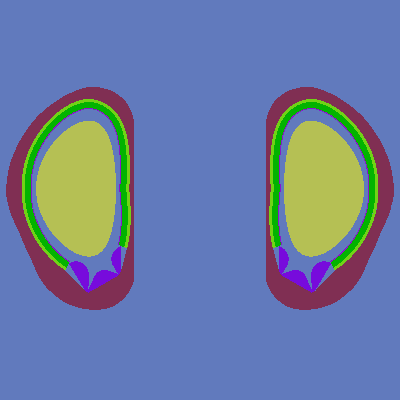

In [26]:
%matplotlib inline
from IPython.display import Image
p = openmc.Plot()
p.basis = 'xz'
p.origin = (0.0, 0.0, 0.0)
p.width = (2000.0, 2000.0)
p.pixels = (400, 400)
p.color_by = 'cell'
openmc.plot_inline(p)

In [19]:
# open the results file
sp = openmc.StatePoint('statepoint.' + str(simulation_batches) + '.h5')

In [20]:
tbr_tally = sp.get_tally(scores=['(n,Xt)'])
df = tbr_tally.get_pandas_dataframe()
df

mesh 1           nuclide   score     mean std. dev.
            x    y    z                                   
0           1    1    1   total  (n,Xt) 0.00e+00  0.00e+00
1           2    1    1   total  (n,Xt) 0.00e+00  0.00e+00
2           3    1    1   total  (n,Xt) 0.00e+00  0.00e+00
3           4    1    1   total  (n,Xt) 0.00e+00  0.00e+00
4           5    1    1   total  (n,Xt) 0.00e+00  0.00e+00
...       ...  ...  ...     ...     ...      ...       ...
999995     96  100  100   total  (n,Xt) 0.00e+00  0.00e+00
999996     97  100  100   total  (n,Xt) 0.00e+00  0.00e+00
999997     98  100  100   total  (n,Xt) 0.00e+00  0.00e+00
999998     99  100  100   total  (n,Xt) 0.00e+00  0.00e+00
999999    100  100  100   total  (n,Xt) 0.00e+00  0.00e+00

[1000000 rows x 7 columns]

In [21]:
tbr_tally_result = df['mean'].sum()

In [22]:
# print result
print('The tritium breeding ratio was found, TBR = ',tbr_tally_result)

The tritium breeding ratio was found, TBR =  0.7810321881586043
